<a href="https://colab.research.google.com/github/jb-rgb/Notebooks-Google-Colab/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de bibliotecas

In [ ]:
# Importar bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Cargar y preparar el conjunto de datos MNIST

In [ ]:
# Cargar el conjunto de datos MNIST
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Normalizar los datos (convertir de 0-255 a 0-1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Redimensionar las imágenes de MNIST (28x28) a 64x64
x_train = tf.image.resize(x_train[..., tf.newaxis], (64, 64))
x_test = tf.image.resize(x_test[..., tf.newaxis], (64, 64))

# Convertir a 3 canales para ResNet50 (grayscale a RGB)
x_train = tf.repeat(x_train, 3, axis=-1)
x_test = tf.repeat(x_test, 3, axis=-1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Visualizar algunas de las imágenes del conjunto de datos

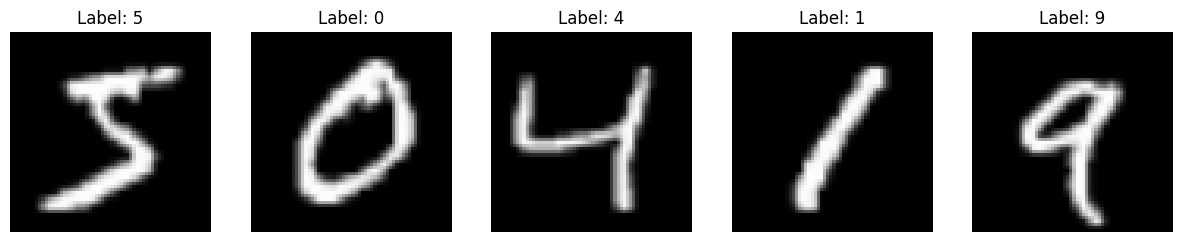

In [ ]:
# Función para visualizar las imágenes
def plot_images(images, labels):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

# Mostrar las primeras 5 imágenes de entrenamiento
plot_images(x_train[:5], y_train[:5])

# Definir el modelo con ResNet50

In [ ]:
# Cargar el modelo ResNet50 preentrenado sin las capas superiores
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Fase 1: Entrenamiento con las capas base congeladas
base_model.trainable = False  # Congelar las capas base
model = models.Sequential([
    base_model,  # Capa base preentrenada
    layers.Flatten(),  # Aplanar las salidas de la red convolucional
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Capa densa con regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(10, activation='softmax')  # Capa de salida con 10 clases (MNIST)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Aumentación de datos

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Entrenamiento inicial con capas base congeladas

In [ ]:
history_freeze = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                           epochs=10,
                           validation_data=(x_test, y_test))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 115s 109ms/step - accuracy: 0.2870 - loss: 2.7195 - val_accuracy: 0.6578 - val_loss: 1.3360
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 126s 98ms/step - accuracy: 0.4796 - loss: 1.6022 - val_accuracy: 0.7037 - val_loss: 1.1444
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 140s 95ms/step - accuracy: 0.5262 - loss: 1.4806 - val_accuracy: 0.7255 - val_loss: 1.0709
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 144s 98ms/step - accuracy: 0.5501 - loss: 1.4172 - val_accuracy: 0.7413 - val_loss: 1.0159
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 141s 98ms/step - accuracy: 0.5661 - loss: 1.3711 - val_accuracy: 0.7543 - val_loss: 0.9844
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 141s 96ms/step - accuracy: 0.5793 - loss: 1.3390 - val_accuracy: 0.7538 - val_loss: 0.9393
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 107ms/step - accuracy: 0.5928 - loss: 1.3097 - val_accuracy: 0.7612 - val_loss: 0.9219
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 98s 104ms/step - accuracy: 0.6005 - loss: 1.2924 - v

# Descongelar capas y volver a entrenar

In [ ]:
# Fase 2: Descongelar las últimas 4 capas y volver a entrenar
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompilar el modelo después de descongelar las capas
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                             epochs=20,
                             validation_data=(x_test, y_test))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 117s 111ms/step - accuracy: 0.5605 - loss: 1.3892 - val_accuracy: 0.7699 - val_loss: 0.8297
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 94s 100ms/step - accuracy: 0.6511 - loss: 1.1400 - val_accuracy: 0.7956 - val_loss: 0.7601
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 95s 101ms/step - accuracy: 0.6808 - loss: 1.0581 - val_accuracy: 0.8231 - val_loss: 0.6955
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 96s 101ms/step - accuracy: 0.7012 - loss: 1.0020 - val_accuracy: 0.8332 - val_loss: 0.6569
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 96s 102ms/step - accuracy: 0.7193 - loss: 0.9559 - val_accuracy: 0.8481 - val_loss: 0.6289
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 135s 95ms/step - accuracy: 0.7277 - loss: 0.9276 - val_accuracy: 0.8472 - val_loss: 0.6212
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 143s 96ms/step - accuracy: 0.7415 - loss: 0.8939 - val_accuracy: 0.8685 - val_loss: 0.5797
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 88s 93ms/step - accuracy: 0.7490 - loss: 0

# Guardar y cargar el modelo

In [ ]:
# Guardar el modelo completo
model.save('modelo_mnist_resnet.h5')  # Guardar en formato HDF5
print("Modelo guardado como 'modelo_mnist_resnet.h5'.")

# Cargar el modelo guardado
from tensorflow.keras.models import load_model
model = load_model('modelo_mnist_resnet.h5')
print("Modelo cargado exitosamente.")

Modelo guardado como 'modelo_mnist_resnet.h5'.


Modelo cargado exitosamente.


# Evaluación del modelo

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Loss: {test_loss}')
print(f'Accuracy: {test_acc}')

313/313 - 10s - 31ms/step - accuracy: 0.9083 - loss: 0.4416
Loss: 0.44163572788238525
Accuracy: 0.90829998254776


# Predicciones y reporte de clasificación

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.99      0.98      0.99      1135
           2       0.88      0.84      0.86      1032
           3       0.79      0.93      0.86      1010
           4       0.93      0.97      0.95       982
           5       0.87      0.71      0.78       892
           6       0.90      0.94      0.92       958
           7       0.93      0.92      0.93      1028
           8       0.90      0.92      0.91       974
           9       0.93      0.87      0.90      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



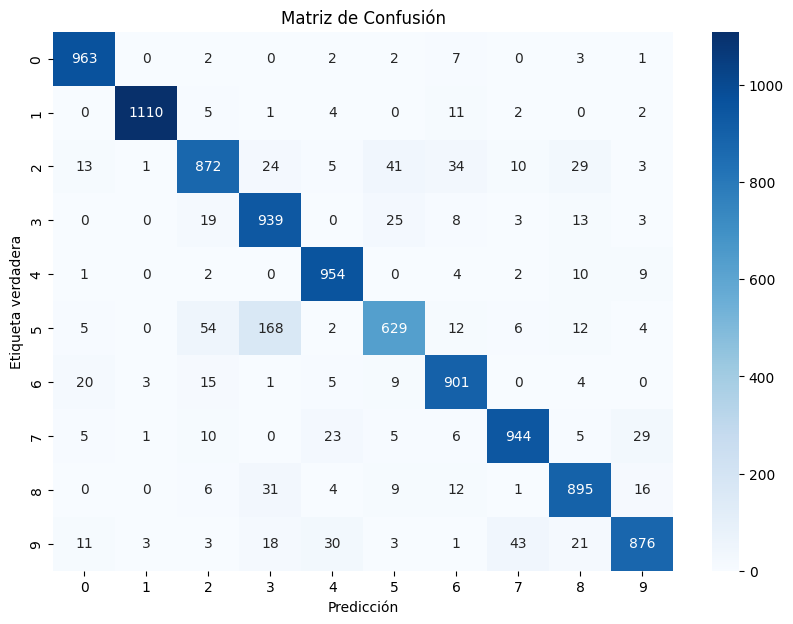

In [ ]:
# Hacer predicciones con el modelo cargado
y_pred = model.predict(x_test)

# Convertir las predicciones a etiquetas (valores enteros)
y_pred_classes = y_pred.argmax(axis=-1)

# Generar el reporte de clasificación
report = classification_report(y_test, y_pred_classes)
print(report)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Visualización de resultados del entrenamiento

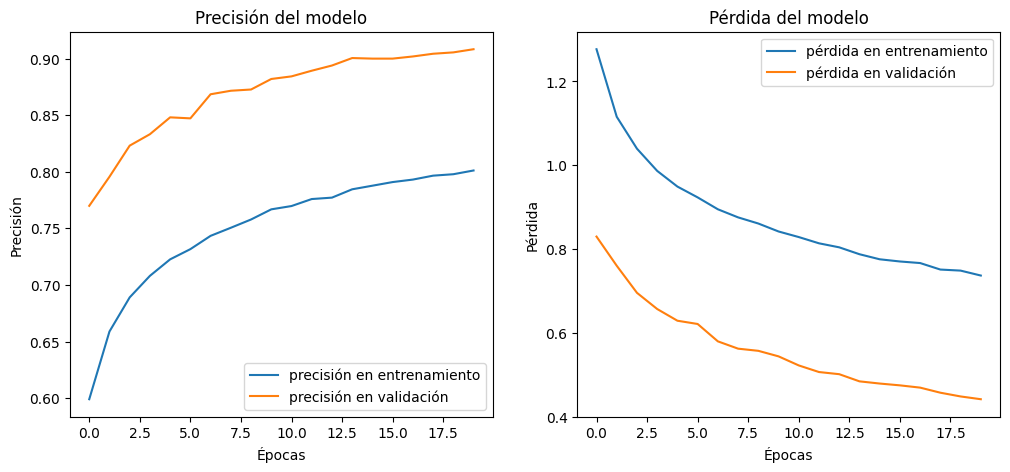

In [ ]:
# Graficar precisión y pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='precisión en entrenamiento')
plt.plot(history_finetune.history['val_accuracy'], label='precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='pérdida en entrenamiento')
plt.plot(history_finetune.history['val_loss'], label='pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()